# Simple Data Generation for Tableau

We will store the data in data frames to aid with exporting to \*.csv files

In [2]:
using DataFrames
using CSV
using Gadfly

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1186
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1186
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/aaron/.julia/packages/Gadfly/ew1SM/src/mapping.jl:228


## Hazard Rate Data ##

To demonstrate the calculation of non-parametric rate estimator standard errors we will generate Makeham casualty events with Gompertz mortality.

## Columnar Event Store Data

From previous work we know that the distribution of length of stays in the health system can be reasonably model with and Erlang phase type (gamma) distribution, usually with 2 to 4 phases, each 16 to 32 times steps long. Samples can be easily generated by summing the appropriate number of exponential distributions. To fully illustrate occupancy and census we need a model that incorporates services that are unavailable. To do this we will use three distributions:

1. Occupied is an Erlang 4 phase with a phase size of 32
2. Unavailable is an Erlang 3 phase with a phase size of 16
3. Vacant is an Erlang 2 phase with a phase size of 8

The three models will be mixed with ratios ${\frac{4}{7},\frac{2}{7},\frac{1}{7}}$ for occupied, unavailable, and vacant, corresponding to an average $\frac{4\times4\times32}{4\times4\times32+1\times2\times8}=97\%$ occupancy. Typical for health system the end time of the stay is included in the length of stay, so that $duration = 1+stop-start$

In [3]:
n = 8192;
stays = DataFrame(
    event = collect(1:n),
    consumer = rand([4,4,4,4,3,3,2], n),
    producer = rand(1:16, n),
    operation = ones(Int64, n)
);
stays[:duration] = ceil.(
    Int64,
    (2 .^(1 .+ stays[:consumer])) .* (cumsum(-log.(1 .- rand(n,4)), dims = 2)[CartesianIndex.(1:n, stays[:consumer])])
)
sort!(stays,[:producer,:event]);
stays[:start] = [1; 1 .+ cumsum(stays[:duration])[1:end-1]];
stays[:stop] = cumsum(stays[:duration]);
stays[:delta] = zeros(Int64, n);
stays[[true; stays[2:end,:producer] .!= stays[1:(end-1),:producer]], :delta] = [
    0; 
    (
        stays[[true; stays[2:end,:producer] .!= stays[1:(end-1),:producer]],:start][2:end] -
        stays[[true; stays[2:end,:producer] .!= stays[1:(end-1),:producer]],:start][1:(end-1)]
    )
];
stays[:delta] = cumsum(stays[:delta]);
stays[:start] = stays[:start] - stays[:delta];
stays[:stop] = stays[:stop] - stays[:delta];
stays[:time] = stays[:start];
stays

,event,consumer,producer,operation,duration,start,stop,delta,time
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,9,3,1,1,79,1,79,0,1
2,24,4,1,1,134,80,213,0,80
3,26,3,1,1,55,214,268,0,214
4,29,3,1,1,25,269,293,0,269
5,53,3,1,1,27,294,320,0,294
6,61,4,1,1,88,321,408,0,321
7,99,2,1,1,17,409,425,0,409
8,100,4,1,1,272,426,697,0,426
9,126,4,1,1,112,698,809,0,698


Quickly plot the durations to qualitatively confirm the model

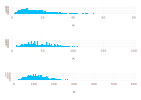

In [4]:
vstack(
    plot(x = stays[:duration][stays[:consumer] .== 2], Geom.histogram),
    plot(x = stays[:duration][stays[:consumer] .== 3], Geom.histogram),
    plot(x = stays[:duration][stays[:consumer] .== 4], Geom.histogram)
)

Copy the data to create the end events

In [17]:
temp = copy(stays);
temp[:operation] = -temp[:operation];
temp[:time] = temp[:stop]
stays = [stays; temp];
sort!(stays,[:producer,:time]);
stays[:record] = 1:(2*n);
stays

,event,consumer,producer,operation,duration,start,stop,delta,time,record
1,1,4,1,1,208,1,208,0,1,1
2,1,4,1,-1,208,1,208,0,208,2
3,8,4,1,1,92,209,300,0,209,3
4,8,4,1,-1,92,209,300,0,300,4
5,15,2,1,1,6,301,306,0,301,5
6,15,2,1,-1,6,301,306,0,306,6
7,23,3,1,1,69,307,375,0,307,7
8,23,3,1,-1,69,307,375,0,375,8
9,29,2,1,1,23,376,398,0,376,9
10,29,2,1,-1,23,376,398,0,398,10


Store the data off in the current working directory

In [18]:
CSV.write("stays.csv", stays)

CSV.Sink{Void,DataType}(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: nothing
        decimal: '.'
        truestring: 'true'
        falsestring: 'false'
        internstrings: true, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "stays.csv", 72, true, String["event", "consumer", "producer", "operation", "duration", "start", "stop", "delta", "time", "record"], 10, false, Val{false})

## Density Estimation Data

To illustrate linear smoothing denity estimation in Tableau we will generate $1024$ samples from a multimodal distribution composed of a mixture of binomial distributions on $\left\lbrace 0,\dots,128 \right\rbrace$, centred at $\left\lbrace 16,32,64\right\rbrace$, with weights $\left\lbrace \frac{2}{7},\frac{4}{7},\frac{1}{7} \right\rbrace$

In [16]:
samples = rand(1024, 128);
binomial = [64/128, 16/128, 16/128, 32/128, 32/128, 32/128, 32/128];
latent = binomial[convert.(Int64, ceil.(7*rand(1024, 1)))][:, 1];
density = DataFrame(
  observation = collect(1:1024),
  probability = latent,
  value = sum(samples .<= latent, dims = 2)[:, 1]
)

,observation,probability,value
,Int64,Float64,Int64
1,1,0.125,10
2,2,0.25,36
3,3,0.25,38
4,4,0.25,35
5,5,0.25,39
6,6,0.25,42
7,7,0.25,28
8,8,0.125,19
9,9,0.25,32


Store the data off in the current working directory.

In [68]:
CSV.write("density.csv", density)

CSV.Sink{Void,DataType}(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: nothing
        decimal: '.'
        truestring: 'true'
        falsestring: 'false'
        internstrings: true, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "density.csv", 30, true, String["observation", "probability", "value"], 3, false, Val{false})

## Lead and Lag Data

To illustrate lead and lag level of detail calculations we will generate $1024$ steps from an $8$ state cyclic Markov process, with random transition probabilities.

We begin with a small helper function to generate the midpoints of a randomly choosen partition of unity.

In [5]:
function randmid(samples::Int64, partitions::Int64)
    temp = [zeros(Float64, samples) sort(rand(samples, partitions-1), 2) ones(Float64, samples)]
    return (temp[:,1:partitions] + temp[:,2:(1 + partitions)])/2
end

randmid (generic function with 1 method)

Quick call to test the generation of the matrix

In [76]:
randmid(8,3)

8×3 Array{Float64,2}:
 0.146474   0.433838  0.787363
 0.234415   0.514168  0.779753
 0.158424   0.519226  0.860802
 0.191161   0.536966  0.845804
 0.120408   0.396235  0.775827
 0.0387037  0.282678  0.743975
 0.0892761  0.484659  0.895383
 0.0582046  0.204756  0.646551

We use a random set of midpoints for the transition probabilities so that we can use the minimum index function to find the next state. Rather than recording the full transition matrix, we use a matrix the represents either step forward, no change, or step back.

In [73]:
function cyclicmarkov(steps::Int64, states::Int64)
    df = DataFrame(
        step = 1:steps,
        state = zeros(Int64, steps),
        transition = zeros(Int64, steps),
        probability = rand(steps),
        map = zeros(Float64, steps)
    )
    transitions = randmid(states, 3)
    for i = 1:(steps-1)
        df[:transition][i] = indmin(abs.(transitions[df[:state][i]+1, :] - df[:probability][i])) - 2
        df[:map][i] = transitions[df[:state][i]+1, df[:transition][i] + 2]
        df[:state][i+1] = (states + df[:transition][i] + df[:state][i]) % states
    end
    return df
end

cyclicmarkov (generic function with 1 method)

Using the simulation function we generate 1024 samples and store them in a dataframe.

In [74]:
leadlag = cyclicmarkov(1024,8)

,step,state,transition,probability,map
1,1,0,0,0.623395,0.636166
2,2,0,1,0.97692,0.97755
3,3,1,0,0.619994,0.565522
4,4,1,-1,0.303467,0.278459
5,5,0,0,0.407829,0.636166
6,6,0,0,0.447096,0.636166
7,7,0,1,0.864404,0.97755
8,8,1,1,0.789972,0.787063
9,9,2,1,0.760125,0.938649
10,10,3,0,0.875706,0.784389


Store the data in the current working directory

In [75]:
CSV.write("leadlag.csv", leadlag)

CSV.Sink{Void,DataType}(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: nothing
        decimal: '.'
        truestring: 'true'
        falsestring: 'false'
        internstrings: true, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "leadlag.csv", 38, true, String["step", "state", "transition", "probability", "map"], 5, false, Val{false})

## Time to First Event Data

We initialize the data frame with 3 columns and 1024 samples

1. The first column contains the subject `subject`, randomly selected from 64 identifiers.
2. The second column contains the precursor to `time`, the cumulative sum of random increments from 1 to 8
3. The third column contains the `event`, randomly selected from a central distribution on the letters A to E

In [45]:
longitudinal = DataFrame(
    subject = sort(rand(1:64, 1024)),
    time = cumsum(rand(1:8, 1024)),
    event = rand(['A', 'B', 'B', 'C', 'C', 'C', 'C', 'D', 'D', 'E'], 1024)
);
longitudinal

,subject,time,event
1,1,4,'B'
2,1,9,'B'
3,1,10,'C'
4,1,17,'C'
5,1,21,'B'
6,1,27,'B'
7,1,35,'A'
8,1,38,'C'
9,1,41,'B'
10,1,47,'B'


Notice that the time is increasing across all subjects. Instead we want to be the cumulative sum strictly within each subject. To accomplish this we use logical indexing to pull the last time from each subject and subtract it from the times of the next subject.

First find the logic index of the row before the subject changed.

In [46]:
longitudinal[:before] = [longitudinal[:subject][1:end-1] .!= longitudinal[:subject][2:end];false];
longitudinal

,subject,time,event,before
1,1,4,'B',false
2,1,9,'B',false
3,1,10,'C',false
4,1,17,'C',false
5,1,21,'B',false
6,1,27,'B',false
7,1,35,'A',false
8,1,38,'C',false
9,1,41,'B',false
10,1,47,'B',false


Similarly find the logical index of the row after the subject changed.

In [47]:
longitudinal[:after] = [false; longitudinal[:before][1:end-1]];
longitudinal

,subject,time,event,before,after
1,1,4,'B',false,false
2,1,9,'B',false,false
3,1,10,'C',false,false
4,1,17,'C',false,false
5,1,21,'B',false,false
6,1,27,'B',false,false
7,1,35,'A',false,false
8,1,38,'C',false,false
9,1,41,'B',false,false
10,1,47,'B',false,false


Next initialize a column to contain the shift of baseline time for each subject.

In [48]:
longitudinal[:shift] = zeros(Int, 1024);
longitudinal

,subject,time,event,before,after,shift
1,1,4,'B',false,false,0
2,1,9,'B',false,false,0
3,1,10,'C',false,false,0
4,1,17,'C',false,false,0
5,1,21,'B',false,false,0
6,1,27,'B',false,false,0
7,1,35,'A',false,false,0
8,1,38,'C',false,false,0
9,1,41,'B',false,false,0
10,1,47,'B',false,false,0


Into the baseline shift of each row following the change in subject place the difference between the successive start times of each subject.

In [49]:
longitudinal[:shift][longitudinal[:after]] = 
    longitudinal[:time][longitudinal[:before]] - 
    [0; longitudinal[:time][longitudinal[:before]][1:end-1]];
longitudinal

,subject,time,event,before,after,shift
1,1,4,'B',false,false,0
2,1,9,'B',false,false,0
3,1,10,'C',false,false,0
4,1,17,'C',false,false,0
5,1,21,'B',false,false,0
6,1,27,'B',false,false,0
7,1,35,'A',false,false,0
8,1,38,'C',false,false,0
9,1,41,'B',false,false,0
10,1,47,'B',false,false,0


Fill in the zeroes by running a cummulative sum over the shift column.

In [50]:
longitudinal[:shift] = cumsum(longitudinal[:shift]);
longitudinal

,subject,time,event,before,after,shift
1,1,4,'B',false,false,0
2,1,9,'B',false,false,0
3,1,10,'C',false,false,0
4,1,17,'C',false,false,0
5,1,21,'B',false,false,0
6,1,27,'B',false,false,0
7,1,35,'A',false,false,0
8,1,38,'C',false,false,0
9,1,41,'B',false,false,0
10,1,47,'B',false,false,0


Rectify the time for each subject by subtracting the baseline shift.

In [20]:
longitudinal[:time] = longitudinal[:time] - longitudinal[:shift];
longitudinal[1:8, :]

,subject,time,event,before,after,shift
1,1,5,C,false,false,0
2,1,7,B,false,false,0
3,1,15,D,false,false,0
4,1,20,B,false,false,0
5,1,24,C,false,false,0
6,1,32,C,false,false,0
7,1,40,C,false,false,0
8,1,45,C,false,false,0


We can now export the data, choosing the first 3 columns.

In [21]:
writetable("longitudinal.csv", longitudinal[[:subject, :time, :event]])

## Contingency Data

The goal is to generate four columns of dimensional classifiers, as two pairs of dependent dimensions. We start by initializing the two distributions to sample:

In [52]:
distributionone = [
    ["A" -1],
    ["A" -1],
    ["A" -1],
    ["A" 0],
    ["A" 0],
    ["A" 1],
    ["B" -1],
    ["B" 0],
    ["B" 0],
    ["B" 1],
    ["B" 1],
    ["B" 1]
];
distributiontwo = [
    ["C" -2],
    ["C" -1],
    ["C" -1],
    ["C" 0],
    ["C" 0],
    ["C" 0],
    ["C" 1],
    ["C" 1],
    ["C" 1],
    ["C" 1],
    ["C" 2],
    ["C" 2],
    ["C" 2],
    ["C" 2],
    ["C" 2],
    ["D" -2],
    ["D" -1],
    ["D" -1],
    ["D" 0],
    ["D" 0],
    ["D" 0],
    ["D" 1],
    ["D" 1],
    ["D" 2],
    ["E" -2],
    ["E" -2],
    ["E" -2],
    ["E" -1],
    ["E" -1],
    ["E" 0],
    ["E" 1],
    ["E" 1],
    ["E" 2],
    ["E" 2],
    ["E" 2],
    ["F" 2],
    ["F" 1],
    ["F" 1],
    ["F" 0],
    ["F" 0],
    ["F" 0],
    ["F" -1],
    ["F" -1],
    ["F" -1],
    ["F" -1],
    ["F" -2],
    ["F" -2],
    ["F" -2],
    ["F" -2],
    ["F" -2]
];

We then generate another 1024 samples to populate a data frame.

In [53]:
contingency = DataFrame(
    sample = 1:1024,
    preonetwo = rand(distributionone, 1024),
    prethreefour = rand(distributiontwo, 1024)
);
contingency[1:8, :]

,sample,preonetwo,prethreefour
1,1,"Any[""B"" 0]","Any[""C"" 0]"
2,2,"Any[""B"" 0]","Any[""C"" 0]"
3,3,"Any[""B"" 1]","Any[""C"" -1]"
4,4,"Any[""B"" -1]","Any[""D"" -1]"
5,5,"Any[""B"" 1]","Any[""F"" 0]"
6,6,"Any[""B"" 0]","Any[""F"" -2]"
7,7,"Any[""B"" 1]","Any[""C"" -1]"
8,8,"Any[""B"" -1]","Any[""C"" 1]"


Next we extract the individual column elements into dimension columns.

In [54]:
contingency[:dimensionone] = vcat(contingency[:, :preonetwo]...)[:, 1];
contingency[:dimensiontwo] = vcat(contingency[:, :preonetwo]...)[:, 2];
contingency[:dimensionthree] = vcat(contingency[:, :prethreefour]...)[:, 1];
contingency[:dimensionfour] = vcat(contingency[:, :prethreefour]...)[:, 2];
contingency[1:8, :]

,sample,preonetwo,prethreefour,dimensionone,dimensiontwo,dimensionthree,dimensionfour
1,1,"Any[""B"" 0]","Any[""C"" 0]",B,0,C,0
2,2,"Any[""B"" 0]","Any[""C"" 0]",B,0,C,0
3,3,"Any[""B"" 1]","Any[""C"" -1]",B,1,C,-1
4,4,"Any[""B"" -1]","Any[""D"" -1]",B,-1,D,-1
5,5,"Any[""B"" 1]","Any[""F"" 0]",B,1,F,0
6,6,"Any[""B"" 0]","Any[""F"" -2]",B,0,F,-2
7,7,"Any[""B"" 1]","Any[""C"" -1]",B,1,C,-1
8,8,"Any[""B"" -1]","Any[""C"" 1]",B,-1,C,1


Finally we export our contingency table data.

In [55]:
writetable("contingency.csv", contingency[[:sample, :dimensionone, :dimensiontwo, :dimensionthree, :dimensionfour]])